In [ ]:
import osmnx
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import scipy.sparse as sp
from local_SE import *
from sklearn.linear_model import LinearRegression
import sklearn

In [11]:
bristol = "Bristol, UK"
new_york = "Empire State Building, New York, USA"

graph = osmnx.graph_from_address(bristol, dist=1000)

In [7]:
graph.number_of_nodes()

10946

In [12]:
nodes = osmnx.graph_to_gdfs(graph, edges=False)
nodes = nodes.reset_index()
edges = osmnx.graph_to_gdfs(graph, nodes=False)


In [ ]:
A = nx.adjacency_matrix(graph)
A = sp.csr_array(A).astype('f')

# change A from directed to undirected
A = A + A.T
A = A.sign()

In [15]:

x = np.array(nodes.x)
y = np.array(nodes.y)
true_coords = np.column_stack((x, y))

13122.448979591836

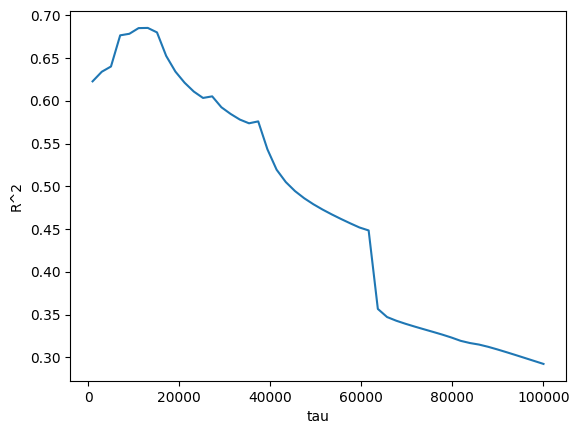

In [ ]:
taus = np.linspace(1000,100000, 50)
r_squareds = []
for tau in taus:

    weights = np.exp(-tau*distances**2)
    # weights = base_weights ** tau
    weights = weights/np.mean(weights)
    X_LASE = local_embedding(A, 20, weights)
    X_LASE = X_LASE[filter]

    true_coords_filtered = true_coords[filter]

    regressor = LinearRegression()
    centered_coords = true_coords_filtered - true_z_coord
    regressor.fit(X_LASE, centered_coords, sample_weight=weights[filter])
    coords_pred = regressor.predict(X_LASE)
    residuals = np.linalg.norm(centered_coords - coords_pred, axis=0)
    r_squared = sklearn.metrics.r2_score(centered_coords, coords_pred)
    r_squareds.append(r_squared)

plt.plot(taus, r_squareds)
plt.xlabel('tau')
plt.ylabel('R^2')

#find the power that maximizes R^2
r_squareds = np.array(r_squareds)
tau = taus[np.argmax(r_squareds)]
tau


In [ ]:
### CAN LOAD RESULTS FROM RUNNING THIS CELL IN FOLLOWING CELL ###

test_size = 10  
ms = np.arange(100, 300, 10)

taus = np.linspace(500, 33000, 30)
z_vals = np.array([100,  200,  300,  400,  600,  700,  900, 1000, 1200, 1300])

K=1

opt_taus = np.zeros((len(z_vals), len(ms)))
opt_plus_vals = np.zeros((len(z_vals), len(ms)))

r2s_subgraph = np.zeros((len(z_vals), len(ms)))
r2s_ASE = np.zeros((len(z_vals), len(ms)))
r2s_LASE = np.zeros((len(z_vals), len(ms)))

mses_baseline = np.zeros((len(z_vals), len(ms)))
mses_subgraph = np.zeros((len(z_vals), len(ms)))
mses_ASE = np.zeros((len(z_vals), len(ms)))
mses_LASE = np.zeros((len(z_vals), len(ms)))

regressor = LinearRegression()

np.random.seed(0)
test_set = np.random.choice(range(100), test_size, replace=False)

for j in range(len(z_vals)):

    print(j)
    d=20
    z = z_vals[j]
    true_z_coord = [nodes.iloc[z].x, nodes.iloc[z].y]

    X_ASE = sparse_SE(A, d)

    for k in range(K):
        for i in range(len(ms)):
            distances = np.linalg.norm(true_coords - true_z_coord, axis=1)
            r_squareds = []
            mses=[]

            filter = np.argsort(distances)[0:ms[i]]
            train_set = np.array(range(ms[i]))[~np.isin(range(ms[i]), test_set)]

            true_coords_filtered = true_coords[filter]
            centered_coords = true_coords_filtered - true_z_coord

            X_ASE_filtered = X_ASE[filter]
            regressor.fit(X_ASE_filtered[train_set], centered_coords[train_set])
            coords_pred_ase_train = regressor.predict(X_ASE_filtered[train_set])
            r_squared_ase = sklearn.metrics.r2_score(centered_coords[train_set], coords_pred_ase_train)
            r2s_ASE[j, i] += r_squared_ase
            coords_pred_ase_test = regressor.predict(X_ASE_filtered[test_set])
            mse_ase = np.mean(np.linalg.norm(centered_coords[test_set] - coords_pred_ase_test, axis=1)**2)
            mses_ASE[j,i] += mse_ase

            mses=[]
            plus_vals = np.arange(0, 100, 10)
            for val in plus_vals:
                filter_plus = np.argsort(distances)[0:ms[i]+val]
                A_subgraph = A[filter_plus, :][:, filter_plus]
                X_subgraph = sparse_SE(A_subgraph, d)[0:ms[i], :]

                regressor.fit(X_subgraph[train_set], centered_coords[train_set])
                coords_pred_subgraph_train = regressor.predict(X_subgraph[train_set])
                mse = np.mean(np.linalg.norm(centered_coords[train_set] - coords_pred_subgraph_train, axis=1)**2)
                mses.append(mse)

            mses = np.array(mses)
            val = plus_vals[np.argmin(mses)]
            opt_plus_vals[j,i] += val

            val = int(opt_plus_vals[j,i])
            filter_plus = np.argsort(distances)[0:ms[i]+val]
            A_subgraph = A[filter_plus, :][:, filter_plus]
            X_subgraph = sparse_SE(A_subgraph, d)[0:ms[i], :]

            regressor.fit(X_subgraph[train_set], centered_coords[train_set])
            coords_pred_subgraph_train = regressor.predict(X_subgraph[train_set])
            coords_pred_subgraph_test = regressor.predict(X_subgraph[test_set])
            mse_subgraph = np.mean(np.linalg.norm(centered_coords[test_set] - coords_pred_subgraph_test, axis=1)**2)
            mses_subgraph[j,i] += mse_subgraph
            r_squared_subgraph = sklearn.metrics.r2_score(centered_coords[train_set], coords_pred_subgraph_train)
            r2s_subgraph[j,i] += r_squared_subgraph

            # baseline prediction for weighting test points
            A_subgraph = A[filter, :][:, filter]
            A_subgraph = A_subgraph.toarray()
            baseline_preds = np.zeros((test_size, 2))
            for l in range(test_size):
                neighbours = np.nonzero(A_subgraph[test_set[l], :])
                neighbours = np.setdiff1d(neighbours, test_set)
                if len(neighbours) == 0:
                    neighbours = np.nonzero((A_subgraph@A_subgraph)[test_set[l], :])
                    neighbours = np.setdiff1d(neighbours, test_set)
                if len(neighbours) == 0:
                    neighbours = np.array([test_set[l]])
                baseline_preds[l, :] = np.mean(true_coords_filtered[neighbours], axis=0)
            distances[filter[test_set]] = np.linalg.norm(baseline_preds - true_z_coord, axis=1)

            # moving average smoother
            weights = np.zeros(A.shape[0])
            weights[filter_plus] = 1
            index = np.argsort(distances)
            window = 50
            smooth_weights = np.zeros(len(weights))
            for k in range(len(weights)):
                start = max(0, k-window)
                end = min(len(weights), k+window)
                smooth_weights[k] = np.mean(weights[index][start:end])

            new_weights = np.zeros(A.shape[0])
            new_weights[index] = smooth_weights
            new_weights = new_weights + np.sort(np.unique(new_weights))[1]/1000

            X_LASE = local_embedding(A, d, new_weights)
            regressor.fit(X_LASE[filter[train_set]], centered_coords[train_set])
            coords_pred = regressor.predict(X_LASE[filter[train_set]])
            r_squared = sklearn.metrics.r2_score(centered_coords[train_set], coords_pred)
            r2s_LASE[j,i] += r_squared

            coords_pred_test = regressor.predict(X_LASE[filter[test_set]])
            mse = np.mean(np.linalg.norm(centered_coords[test_set] - coords_pred_test, axis=1)**2)
            mses_LASE[j,i] += mse
            

r2s_ASE = r2s_ASE/K
r2s_subgraph = r2s_subgraph/K
r2s_LASE = r2s_LASE/K
mses_ASE = mses_ASE/K
mses_subgraph = mses_subgraph/K
mses_LASE = mses_LASE/K
opt_taus = opt_taus/K
opt_plus_vals = opt_plus_vals/K


0
1
2
3
4
5
6
7
8
9


In [ ]:
import pickle

# # save the results
# results = {'r2s_ASE': r2s_ASE, 'r2s_subgraph': r2s_subgraph, 'r2s_LASE': r2s_LASE, 
#            'mses_ASE': mses_ASE, 'mses_subgraph': mses_subgraph, 'mses_LASE': mses_LASE,
#            'opt_taus': opt_taus, 'opt_plus_vals': opt_plus_vals}
# with open('regression_results/lr_d3.pkl', 'wb') as f:
#     pickle.dump(results, f)

#load the results used in the paper
with open('regression_results/lr_d3.pkl', 'rb') as f:
    results = pickle.load(f)

r2s_ASE = results['r2s_ASE']
r2s_subgraph = results['r2s_subgraph']
r2s_LASE = results['r2s_LASE']
mses_ASE = results['mses_ASE']
mses_subgraph = results['mses_subgraph']
mses_LASE = results['mses_LASE']
opt_taus = results['opt_taus']
opt_plus_vals = results['opt_plus_vals']

ms = np.arange(100, 300, 10)
z_vals = np.array([100,  200,  300,  400,  600,  700,  900, 1000, 1200, 1300])


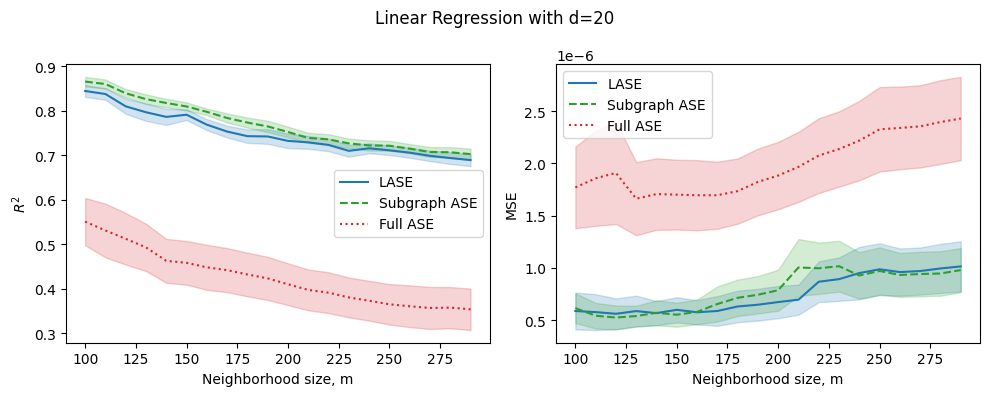

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

color = 'tab:blue'
ax1.set_xlabel('Neighborhood size, m')
ax1.set_ylabel(r'$R^2$')
ax1.plot(ms, np.mean(r2s_LASE, axis=0), color=color, label='LASE')
ax1.fill_between(ms, np.mean(r2s_LASE, axis=0) - np.std(r2s_LASE, axis=0)/np.sqrt(len(z_vals)), np.mean(r2s_LASE, axis=0) + np.std(r2s_LASE, axis=0)/np.sqrt(len(z_vals)), color=color, alpha=0.2)
color = 'tab:green'
ax1.plot(ms, np.mean(r2s_subgraph, axis=0), color=color, linestyle='--', label='Subgraph ASE')
ax1.fill_between(ms, np.mean(r2s_subgraph, axis=0) - np.std(r2s_subgraph, axis=0)/np.sqrt(len(z_vals)), np.mean(r2s_subgraph, axis=0) + np.std(r2s_subgraph, axis=0)/np.sqrt(len(z_vals)), color=color, alpha=0.2)
color = 'tab:red'
ax1.plot(ms, np.mean(r2s_ASE, axis=0), color=color, linestyle=':', label='Full ASE')
ax1.fill_between(ms, np.mean(r2s_ASE, axis=0) - np.std(r2s_ASE, axis=0)/np.sqrt(len(z_vals)), np.mean(r2s_ASE, axis=0) + np.std(r2s_ASE, axis=0)/np.sqrt(len(z_vals)), color=color, alpha=0.2)

ax1.legend()

color = 'tab:blue'
ax2.set_xlabel('Neighborhood size, m')
ax2.set_ylabel('MSE')
ax2.plot(ms, np.mean(mses_LASE, axis=0), color=color, label='LASE')
ax2.fill_between(ms, np.mean(mses_LASE, axis=0) - np.std(mses_LASE, axis=0)/np.sqrt(len(mses_LASE)), np.mean(mses_LASE, axis=0) + np.std(mses_LASE, axis=0)/np.sqrt(len(mses_LASE)), color=color, alpha=0.2)
color = 'tab:green'
ax2.plot(ms, np.mean(mses_subgraph, axis=0), color=color, linestyle='--', label='Subgraph ASE')
ax2.fill_between(ms, np.mean(mses_subgraph, axis=0) - np.std(mses_subgraph, axis=0)/np.sqrt(len(z_vals)), np.mean(mses_subgraph, axis=0) + np.std(mses_subgraph, axis=0)/np.sqrt(len(z_vals)), color=color, alpha=0.2)
color = 'tab:red'
ax2.plot(ms, np.mean(mses_ASE, axis=0), color=color, linestyle=':', label='Full ASE')
ax2.fill_between(ms, np.mean(mses_ASE, axis=0) - np.std(mses_ASE, axis=0)/np.sqrt(len(z_vals)), np.mean(mses_ASE, axis=0) + np.std(mses_ASE, axis=0)/np.sqrt(len(z_vals)), color=color, alpha=0.2)

ax2.legend()
#set overall title
fig.suptitle('Linear Regression with d=20')

fig.tight_layout()
plt.show()
